In [1]:
import os
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white', {'xtick.bottom': True, 'ytick.left': True})
sns.set_context('notebook', font_scale=2)

In [2]:
# color scheme for figures
import visual_behavior.ophys.response_analysis.utilities as ut
colors = ut.get_colors_for_image_sets()

In [3]:
experiment_dir = '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_pilot_analysis/visual_behavior_pilot_manuscript_initial_submission/'
model_dir = '/allen/programs/braintv/workgroups/cortexmodels/brianh/exps/stsp_final/noise_std_0.5_pos_weight_5_l2_pen_0.001_patience_5/RESULT/'

# Response rates to different flashes

In [4]:
# load response rate summary df
df = pd.read_hdf(os.path.join(experiment_dir, 'multi_session_summary_dfs', 'response_rate_summary_df_engaged.h5'))

In [5]:
metrics = ['hit_rate', 'catch_fa_rate', 'fraction_flashes_with_licks', 'omitted_flash_response_rate', 'post_omitted_flash_response_rate']

In [6]:
# image set A
experiment_df = df[(df.image_set=='A')&(df.cre_line=='Slc17a7-IRES2-Cre')][metrics]

In [7]:
# model results
model_dict = {}
for model in ['STSPNet', 'RNN']:
    model_dict[model] = {}
    model_dict[model]['hr'] = []
    model_dict[model]['far'] = []
    model_dict[model]['all_flashes'] = []
    model_dict[model]['omitted_flashes'] = []
    model_dict[model]['post_omitted_flashes'] = []
    for seed in range(1,11):
        temp = pickle.load(open(model_dir+model+'/'+model+'_A_'+str(seed)+'.pkl', 'rb'))
        model_dict[model]['hr'].append(temp['hr'])
        model_dict[model]['far'].append(temp['far'])
        model_dict[model]['all_flashes'].append(temp['all_flashes'])
        model_dict[model]['omitted_flashes'].append(temp['omitted_flashes'])

        # recompute based conditionally on omitted flash response rate
        omit_idx = np.where(temp['omit'])
        omit_idx = (omit_idx[0][omit_idx[1]<196], omit_idx[1][omit_idx[1]<196])
        post_omit_idx = np.where((np.pad(temp['omit'], ((0, 0), (3, 0)), mode='constant')[:, :-3]))
        post_omit_rr = ((temp['pred'][post_omit_idx[0], post_omit_idx[1]])&
                        (temp['pred'][omit_idx[0], omit_idx[1]]==0)).sum() / len(post_omit_idx[0])
        model_dict[model]['post_omitted_flashes'].append(post_omit_rr)
    
    model_dict[model]['hr'] = np.array(model_dict[model]['hr'])
    model_dict[model]['far'] = np.array(model_dict[model]['far'])
    model_dict[model]['all_flashes'] = np.array(model_dict[model]['all_flashes'])
    model_dict[model]['omitted_flashes'] = np.array(model_dict[model]['omitted_flashes'])
    model_dict[model]['post_omitted_flashes'] = np.array(model_dict[model]['post_omitted_flashes'])

# Create one dataframe

In [108]:
experiment_df.loc[:, 'model'] = 'Experiment'

# STSP
stsp_df = pd.DataFrame({'model': 'STPNet', 'hit_rate': model_dict['STSPNet']['hr'], 'catch_fa_rate': model_dict['STSPNet']['far'], 'fraction_flashes_with_licks': model_dict['STSPNet']['all_flashes'], 'omitted_flash_response_rate': model_dict['STSPNet']['omitted_flashes'], 'post_omitted_flash_response_rate': model_dict['STSPNet']['post_omitted_flashes']})

# RNN
rnn_df = pd.DataFrame({'model': 'RNN', 'hit_rate': model_dict['RNN']['hr'], 'catch_fa_rate': model_dict['RNN']['far'], 'fraction_flashes_with_licks': model_dict['RNN']['all_flashes'], 'omitted_flash_response_rate': model_dict['RNN']['omitted_flashes'], 'post_omitted_flash_response_rate': model_dict['RNN']['post_omitted_flashes']})

df_all = pd.concat((experiment_df, stsp_df, rnn_df), ignore_index=True)

/home/brianh/miniconda3/envs/vis-behav/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [109]:
# melt data frames to get into single column
df_all = pd.melt(df_all, id_vars=['model'], value_vars=['hit_rate', 'catch_fa_rate', 'fraction_flashes_with_licks', 'omitted_flash_response_rate', 'post_omitted_flash_response_rate'], var_name='condition',  value_name='response probability')
df_all.loc[df_all.condition=='hit_rate', 'condition'] = 'go trials'
df_all.loc[df_all.condition=='catch_fa_rate', 'condition'] = 'catch trials'
df_all.loc[df_all.condition=='fraction_flashes_with_licks', 'condition'] = 'all'
df_all.loc[df_all.condition=='omitted_flash_response_rate', 'condition'] = 'omitted'
df_all.loc[df_all.condition=='post_omitted_flash_response_rate', 'condition'] = 'post-omitted'

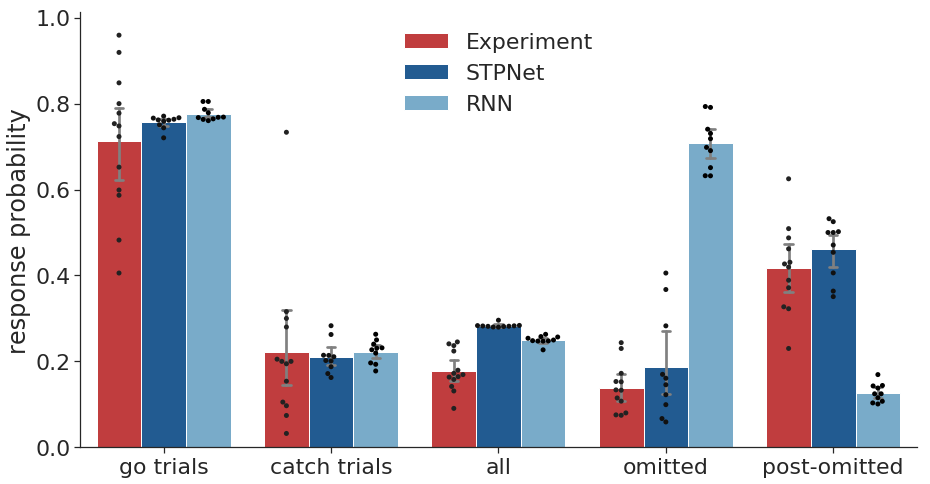

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))

sns.barplot(x='condition', y='response probability', data=df_all, hue='model', palette=[colors[0], colors[1], colors[3]], errcolor='gray', capsize=0.05)
g = sns.swarmplot(x='condition', y='response probability', data=df_all, hue='model', dodge=True, color='black')
ax.set_xlabel('')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[3:], labels=labels[3:], frameon=False)
# g.legend_.remove()

# Hide the right and top spines
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

In [111]:
fig.savefig('figures/omitted_flash.png', dpi=300, bbox_inches='tight')

# mean omission response

In [8]:
from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis

In [9]:
experiment_id = df[(df.image_set=='A')&(df.cre_line=='Slc17a7-IRES2-Cre')].experiment_id.values

In [10]:
cache_dir = r'/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_pilot_analysis/visual_behavior_pilot_manuscript_initial_submission'
dataset= VisualBehaviorOphysDataset(experiment_id[9], cache_dir=cache_dir)  # 1, 4, 6, 9 are good experiments
analysis = ResponseAnalysis(dataset, use_events=False)

# get trials and flash dataframe
odf = analysis.omitted_flash_response_df

loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe


In [11]:
# don't include last flash
omission_trace = odf[odf.flash_number!=odf.flash_number.max()].groupby('cell').trace.apply(np.mean)
omission_trace = np.stack(omission_trace)

# sort by original 500ms trace window
# idx = np.argsort(odf[odf.flash_number!=odf.flash_number.max()].groupby('cell').mean_response.mean())[::-1]

Text(0,0.5,'cells')

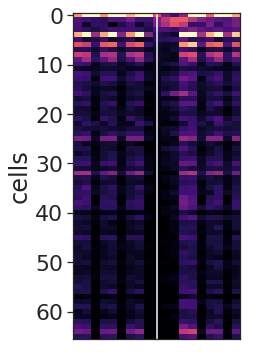

In [15]:
fig, ax = plt.subplots(figsize=(3,6))

# extract relevant portion of the trace
# omission_response_new = omission_trace[idx, int(31*.75):int(31*5.25)]
omission_response_new = omission_trace[:, int(31*.75):int(31*5.25)]

# bin with 250 ms windows
omission_response_mean = np.zeros((omission_response_new.shape[0], 19))
for i, bin in enumerate(np.linspace(.75, 5.5, 20)[:-1]):
#     omission_response_mean[:,i] = omission_trace[idx, int(31*bin):int(31*(bin+.25))].mean(axis=1)
    omission_response_mean[:,i] = omission_trace[:, int(31*bin):int(31*(bin+.25))].mean(axis=1)

idx = np.argsort(omission_response_mean[:,9])[::-1]
    
# ax.imshow(omission_response_new, vmin=0, vmax=0.5*omission_response_new.max(), cmap='magma', aspect='auto')
# ax.axvline([69], color='white')
ax.imshow(omission_response_mean[idx], vmin=0, vmax=0.5*omission_response_mean.max(), cmap='magma', aspect='auto')
ax.axvline([9], color='white')

# ax.set_xticks(np.linspace(0, omission_response_new.shape[1]-1, 3))
# ax.set_xticklabels([str(i) for i in np.arange(-2.25,3,2.25)])
# ax.set_xlabel('time after omit (s)')

ax.set_xticks([])
ax.set_ylabel('cells')

In [16]:
fig.savefig('figures/neural_population_omit_binned.png', dpi=300, bbox_inches='tight')

Text(0,0.5,'mean dF/F')

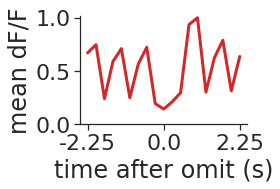

In [17]:
sns.set_style({'axes.spines.right': False, 'axes.spines.top': False})

fig, ax = plt.subplots(figsize=(3,2))

# normalize these traces
# ax.plot(omission_response_new.mean(axis=0) / omission_response_new.mean(axis=0).max(), color=colors[0], linewidth=3)
# ax.set_xticks(np.linspace(0, omission_response_new.shape[1]-1, 3))

ax.plot(omission_response_mean.mean(axis=0) / omission_response_mean.mean(axis=0).max(), color=colors[0], linewidth=3)
ax.set_xticks(np.linspace(0, omission_response_mean.shape[1]-1, 3))

plt.yticks([0, 0.5, 1])
plt.ylim([0, 1.02])
ax.set_xticklabels([str(i) for i in np.arange(-2.25,3,2.25)])

ax.set_xlabel('time after omit (s)')
ax.set_ylabel('mean dF/F')

In [18]:
fig.savefig('figures/neural_psth_omit_binned.png', dpi=300, bbox_inches='tight')

# Omitted responses

Text(0,0.5,'units')

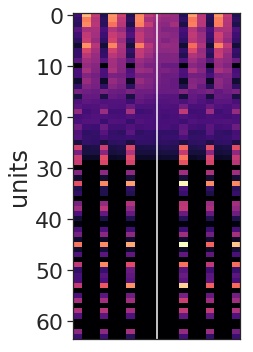

In [4]:
# Load a sample model
model_data = pickle.load(open(model_dir+'STSPNet'+'/STSPNet_A_1.pkl'))

input_act = model_data['input']
hidden_act = model_data['hidden']
labels = model_data['labels']
image = model_data['image']
omit = model_data['omit']

# find omitted trials
idx = np.argwhere(omit==1)

omit_trial = []
for trial in idx:
    trial_chunk = input_act[trial[0], (trial[1]-9):(trial[1]+9+1)]
    if trial_chunk.shape[0] == 19:
        omit_trial.append(trial_chunk)
        
omit_trial = np.stack(omit_trial).mean(axis=0).transpose()

# sort by mean omitted response
idx = np.argsort(omit_trial[:,9])[::-1]

sns.set_style({'xtick.bottom': True, 'ytick.left': True,})
plt.figure(figsize=(3,6))
plt.imshow(omit_trial[idx,:], vmin=0, vmax=omit_trial[idx,:].max(), cmap='magma', aspect='auto')
plt.axvline([9], color='white')

# plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))
# plt.xlabel('time after omit (s)')

plt.xticks([])
plt.ylabel('units')

# plt.savefig('figures/example_stsp_omit_response.png', dpi=300, bbox_inches='tight')

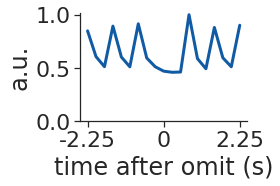

In [8]:
fig, ax = plt.subplots(figsize=(3,2))

# normalize this trace
plt.plot(omit_trial.mean(axis=0) / omit_trial.mean(axis=0).max(), color=colors[1], linewidth=3)
plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))
plt.yticks([0, 0.5, 1])
plt.ylim([0, 1.02])

ax.set_xlabel('time after omit (s)')
ax.set_ylabel('a.u.')

fig.savefig('figures/example_stsp_omit_psth.png', dpi=300, bbox_inches='tight')

Text(0,0.5,'units')

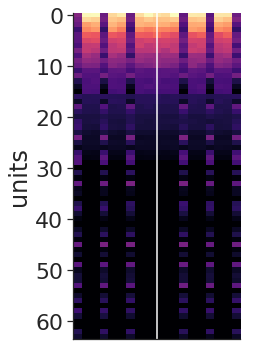

In [9]:
# Load a sample model
model_data = pickle.load(open(model_dir+'RNN'+'/RNN_A_1.pkl'))

input_act = model_data['input']
hidden_act = model_data['hidden']
labels = model_data['labels']
image = model_data['image']
omit = model_data['omit']

# find omit trials
idx = np.argwhere(omit==1)

omit_trial = []
for trial in idx:
    trial_chunk = input_act[trial[0], (trial[1]-9):(trial[1]+9+1)]
    if trial_chunk.shape[0] == 19:
        omit_trial.append(trial_chunk)
        
omit_trial = np.stack(omit_trial).mean(axis=0).transpose()

# sort by mean omitted response
idx = np.argsort(omit_trial[:,9])[::-1]

sns.set_style({'xtick.bottom': True, 'ytick.left': True,})
plt.figure(figsize=(3,6))
plt.imshow(omit_trial[idx,:], vmin=0, vmax=omit_trial[idx,:].max(), cmap='magma', aspect='auto')
plt.axvline([9], color='white')

# plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))
# plt.xlabel('time after omit (s)')

plt.xticks([])
plt.ylabel('units')

# plt.savefig('figures/example_rnn_omit_response.png', dpi=300, bbox_inches='tight')

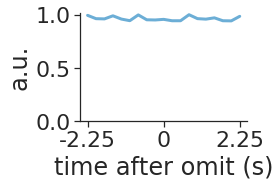

In [7]:
fig, ax = plt.subplots(figsize=(3,2))

# normalize this trace
plt.plot(omit_trial.mean(axis=0) / omit_trial.mean(axis=0).max(), color=colors[3], linewidth=3)
plt.xticks(np.linspace(0,18,3), (-2.25, 0, 2.25))
plt.yticks([0, 0.5, 1])
plt.ylim([0, 1.02])

ax.set_xlabel('time after omit (s)')
ax.set_ylabel('a.u.')

fig.savefig('figures/example_rnn_omit_psth.png', dpi=300, bbox_inches='tight')